# LIBRARIES


In [5]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline
import io
import os
import math
import copy
import pickle
import zipfile
from textwrap import wrap
from pathlib import Path
from itertools import zip_longest
from collections import defaultdict
from urllib.error import URLError
from urllib.request import urlopen
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F 
from torch.optim.lr_scheduler import _LRScheduler
plt.style.use('ggplot')
print(np.__version__)
print(pd.__version__)
print(torch.__version__)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.21.6
1.3.5
1.12.1+cu113


# DATA EXTRACTION

In [89]:
unames = ['user_id', 'gender', 'age', 'occupation', 'zip']
users = pd.read_table("/content/users.dat", sep='::',
 header=None, names=unames, engine='python')
rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_table('/content/ratings.dat', sep='::',
 header=None, names=rnames, engine='python')
mnames = ['movie_id', 'title', 'genres']
movies = pd.read_table('/content/movies.dat', sep='::',encoding = "iso8859-1",
 header=None, names=mnames, engine='python')

In [81]:
users[:5]

,user_id,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [8]:
print(ratings.shape)
print(movies.shape)
ratings.info()
movies.info()

(1000209, 4)
(3883, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1000209 non-null  int64
 1   movie_id   1000209 non-null  int64
 2   rating     1000209 non-null  int64
 3   timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  3883 non-null   int64 
 1   title     3883 non-null   object
 2   genres    3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


In [9]:
min_rating = min(ratings["rating"])
max_rating = max(ratings["rating"])
print(min_rating)
print(max_rating)

1
5


# CREATION OF DATASET


In [10]:
def create_dataset(ratings, top=None):
    if top is not None:
        ratings.groupby('user_id')['rating'].count()
    
    unique_users = ratings.user_id.unique()
    user_to_index = {old: new for new, old in enumerate(unique_users)}
    new_users = ratings.user_id.map(user_to_index)
    
    unique_movies = ratings.movie_id.unique()
    movie_to_index = {old: new for new, old in enumerate(unique_movies)}
    new_movies = ratings.movie_id.map(movie_to_index)
    
    n_users = unique_users.shape[0]
    n_movies = unique_movies.shape[0]
    
    X = pd.DataFrame({'user_id': new_users, 'movie_id': new_movies})
    y = ratings['rating'].astype(np.float32)
    return (n_users, n_movies), (X, y), (user_to_index, movie_to_index)

In [11]:
(num_users, num_movies), (X, y), _ = create_dataset(ratings)
print(f'Embeddings: {num_users} users, {num_movies} movies')
print(f'Dataset shape: {X.shape}')
print(f'Target shape: {y.shape}')

Embeddings: 6040 users, 3706 movies
Dataset shape: (1000209, 2)
Target shape: (1000209,)


In [12]:
ratings = ratings.sample(frac=1, random_state=42)
x = ratings[["user_id", "movie_id"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = ratings["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.8 * ratings.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

# MODEL WITH DROPOUT 

In [13]:
EMBEDDING_SIZE = 50
class EmbeddingNet(nn.Module):
    """
    Creates a dense network with embedding layers.
    
    Args:
    
        n_users:            
            Number of unique users in the dataset.

        n_movies: 
            Number of unique movies in the dataset.

        n_factors: 
            Number of columns in the embeddings matrix.

        embedding_dropout: 
            Dropout rate to apply right after embeddings layer.

        hidden:
            A single integer or a list of integers defining the number of 
            units in hidden layer(s).

        dropouts: 
            A single integer or a list of integers defining the dropout 
            layers rates applyied right after each of hidden layers.
            
    """
    def __init__(self, n_users, n_movies,
                 embedding_size=50, embedding_dropout=0.02, 
                 hidden=10, dropouts=0.2):
        super().__init__()
        hidden = get_list(hidden)
        dropouts = get_list(dropouts)
        n_last = hidden[-1]
        
        def gen_layers(n_in):
            """
            A generator that yields a sequence of hidden layers and 
            their activations/dropouts.
            
            Note that the function captures `hidden` and `dropouts` 
            values from the outer scope.
            """
            nonlocal hidden, dropouts
            assert len(dropouts) <= len(hidden)
            
            for n_out, rate in zip_longest(hidden, dropouts):
                yield nn.Linear(n_in, n_out)
                yield nn.ReLU()
                if rate is not None and rate > 0.:
                    yield nn.Dropout(rate)
                n_in = n_out
            
        self.u = nn.Embedding(n_users, embedding_size)
        self.m = nn.Embedding(n_movies, embedding_size)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden = nn.Sequential(*list(gen_layers(embedding_size * 2)))
        self.fc = nn.Linear(n_last, 1)
        self._init()
        
    def forward(self, users, movies, minmax=None):
        features = torch.cat([self.u(users), self.m(movies)], dim=1)
        x = self.drop(features)
        x = self.hidden(x)
        out = torch.sigmoid(self.fc(x))
        if minmax is not None:
            min_rating, max_rating = minmax
            out = out*(max_rating - min_rating + 1) + min_rating - 0.5
        return out
    
    def _init(self):
        """
        Setup embeddings and hidden layers with reasonable initial values.
        """
        def init(m):
            if type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
                
        self.u.weight.data.uniform_(-0.05, 0.05)
        self.m.weight.data.uniform_(-0.05, 0.05)
        self.hidden.apply(init)
        init(self.fc)
    
    
def get_list(n):
    if isinstance(n, (int, float)):
        return [n]
    elif hasattr(n, '__iter__'):
        return list(n)
    raise TypeError('layers configuraiton should be a single number or a list of numbers')

# CREATION OF MODEL

In [14]:
model = EmbeddingNet(num_users, num_movies, EMBEDDING_SIZE)
print(model)

EmbeddingNet(
  (u): Embedding(6040, 50)
  (m): Embedding(3706, 50)
  (drop): Dropout(p=0.02, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=100, out_features=10, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (fc): Linear(in_features=10, out_features=1, bias=True)
)


In [15]:
model2 = EmbeddingNet(num_users, num_movies, embedding_size =150, hidden=[100, 200, 300], dropouts=[0.25, 0.5])
print(model2)

EmbeddingNet(
  (u): Embedding(6040, 150)
  (m): Embedding(3706, 150)
  (drop): Dropout(p=0.02, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=100, out_features=200, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=200, out_features=300, bias=True)
    (7): ReLU()
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
)


#PLOTS

In [16]:
def triangular(step_size, max_lr, method='triangular', gamma=0.99):
    
    def scheduler(epoch, base_lr):
        period = 2 * step_size
        cycle = math.floor(1 + epoch/period)
        x = abs(epoch/step_size - 2*cycle + 1)
        delta = (max_lr - base_lr)*max(0, (1 - x))

        if method == 'triangular':
            pass  # we've already done
        elif method == 'triangular2':
            delta /= float(2 ** (cycle - 1))
        elif method == 'exp_range':
            delta *= (gamma**epoch)
        else:
            raise ValueError('unexpected method: %s' % method)
            
        return base_lr + delta
        
    return scheduler

In [17]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + math.cos(math.pi*t/t_max))/2
    
    return scheduler

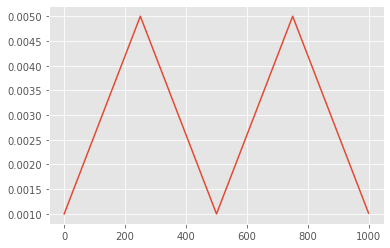

In [18]:
def plot_lr(schedule):
    ts = list(range(1000))
    y = [schedule(t, 0.001) for t in ts]
    plt.plot(ts, y)
plot_lr(triangular(250, 0.005))

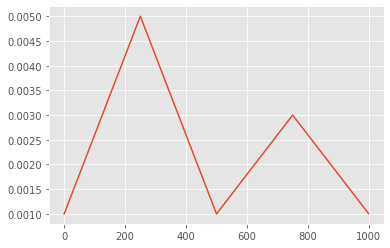

In [19]:
plot_lr(triangular(250, 0.005, 'triangular2'))

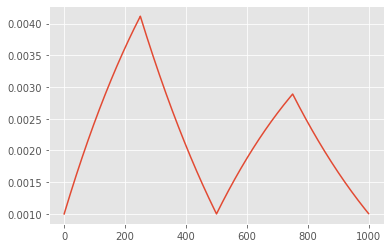

In [20]:
plot_lr(triangular(250, 0.005, 'exp_range', gamma=0.999))

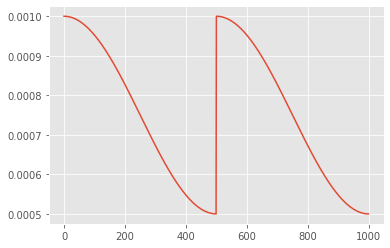

In [21]:
plot_lr(cosine(t_max=500, eta_min=0.0005))

In [22]:
def set_random_seed(state=1):
    gens = (np.random.seed, torch.manual_seed, torch.cuda.manual_seed)
    for set_state in gens:
        set_state(state)

RANDOM_STATE = 1
set_random_seed(RANDOM_STATE)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
datasets = {'train': (X_train, y_train), 'val': (X_valid, y_valid)}
dataset_sizes = {'train': len(X_train), 'val': len(X_valid)}

# NEW MODEL

In [23]:
net = EmbeddingNet(
    n_users=num_users, n_movies=num_movies, 
    embedding_size=150, hidden=[500, 500, 500], 
    embedding_dropout=0.05, dropouts=[0.5, 0.5, 0.25])

In [24]:
print(num_users,num_movies)

6040 3706


In [25]:
from torch.optim.lr_scheduler import _LRScheduler
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

In [26]:
# TO MAKE BATCHES

In [27]:
class ReviewsIterator:
    
    def __init__(self, X, y, batch_size=32, shuffle=True):
        X, y = np.asarray(X), np.asarray(y)
        
        if shuffle:
            index = np.random.permutation(X.shape[0])
            X, y = X[index], y[index]
            
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0
        
    def __iter__(self):
      return self
    
    def __next__(self):
        return self.next()
    
    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k*bs:(k + 1)*bs], self.y[k*bs:(k + 1)*bs]

In [28]:
def batches(X, y, bs=32, shuffle=True):
    for xb, yb in ReviewsIterator(X, y, bs, shuffle):
        xb = torch.LongTensor(xb)
        yb = torch.FloatTensor(yb)
        yield xb, yb.view(-1, 1) 

In [29]:
for x_batch, y_batch in batches(X, y, bs=4):
    print(x_batch)
    print(y_batch)
    break

tensor([[3808, 2234],
        [1388,  143],
        [4509,  849],
        [1016, 2393]])
tensor([[0.5000],
        [0.5000],
        [1.0000],
        [0.5000]])


#TRAINING

In [30]:
lr = 1e-3
wd = 1e-5
bs = 2000 
n_epochs = 100
patience = 10
no_improvements = 0
best_loss = np.inf
best_weights = None
history = []
lr_history = []
minmax = ratings.rating.min(), ratings.rating.max()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
iterations_per_epoch = int(math.ceil(dataset_sizes['train'] // bs))
scheduler = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/10))

for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}
    
    for phase in ('train', 'val'):
        training = phase == 'train'
        running_loss = 0.0
        n_batches = 0
        batch_num = 0
        for batch in batches(*datasets[phase], shuffle=training, bs=bs):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()
            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(training):
                outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
                loss = criterion(outputs, y_batch)
                
                # don't update weights and rates when in 'val' phase
                if training:
                    scheduler.step()
                    loss.backward()
                    optimizer.step()
                    lr_history.extend(scheduler.get_lr())
                    
            running_loss += loss.item()
            
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        
        # early stopping: save weights of the best model so far
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                best_weights = copy.deepcopy(net.state_dict())
                no_improvements = 0
            else:
                no_improvements += 1
                
    history.append(stats)
    print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


loss improvement on epoch: 1
[001/100] train: 0.1135 - val: 0.0989
[002/100] train: 0.0992 - val: 0.0989
[003/100] train: 0.0992 - val: 0.0989
[004/100] train: 0.0992 - val: 0.0989
[005/100] train: 0.0992 - val: 0.0989
[006/100] train: 0.0992 - val: 0.0989
[007/100] train: 0.0992 - val: 0.0989
[008/100] train: 0.0992 - val: 0.0989
[009/100] train: 0.0992 - val: 0.0989
[010/100] train: 0.0992 - val: 0.0989
[011/100] train: 0.0992 - val: 0.0989
early stopping after epoch 011


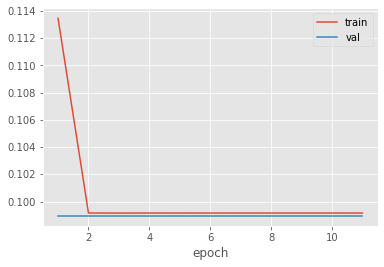

In [31]:
ax = pd.DataFrame(history).drop(columns='total').plot(x='epoch')

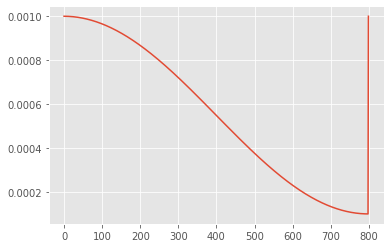

In [32]:
_ = plt.plot(lr_history[:2*iterations_per_epoch])

In [33]:
net.load_state_dict(best_weights)

<All keys matched successfully>

#ERROR

In [34]:
groud_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['val'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

In [35]:
final_loss = np.sqrt(np.mean((np.array(predictions) - np.array(groud_truth))**2))
print(f'Final RMSE: {final_loss:.4f}')

Final RMSE: 0.3146


In [36]:
np.array(predictions)

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

In [37]:
with open('best.weights', 'wb') as file:
    pickle.dump(best_weights, file)

In [38]:
##############################
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(ratings, test_size = 0.20, random_state = 42)

print(X_train.shape)
print(X_test.shape)

(800167, 4)
(200042, 4)


In [39]:
user_data = X_train.pivot(index = 'user_id', columns = 'movie_id', values = 'rating').fillna(0)
user_data.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
# make a copy of train and test datasets
dummy_train = X_train.copy()
dummy_test = X_test.copy()

dummy_train['rating'] = dummy_train['rating'].apply(lambda x: 0 if x > 0 else 1)
dummy_test['rating'] = dummy_test['rating'].apply(lambda x: 1 if x > 0 else 0)

In [41]:
# The movies not rated by user is marked as 1 for prediction 
dummy_train = dummy_train.pivot(index = 'user_id', columns = 'movie_id', values = 'rating').fillna(1)

# The movies not rated by user is marked as 0 for evaluation 
dummy_test = dummy_test.pivot(index ='user_id', columns = 'movie_id', values = 'rating').fillna(0)
dummy_train.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [42]:
from sklearn.metrics.pairwise import cosine_similarity

# User Similarity Matrix using Cosine similarity as a similarity measure between Users
user_similarity = cosine_similarity(user_data)
user_similarity[np.isnan(user_similarity)] = 0
print(user_similarity)
print(user_similarity.shape)

[[1.         0.09914111 0.07544222 ... 0.         0.13187831 0.11358346]
 [0.09914111 1.         0.07325784 ... 0.08320016 0.06084783 0.2158268 ]
 [0.07544222 0.07325784 1.         ... 0.09453802 0.11893674 0.12684597]
 ...
 [0.         0.08320016 0.09453802 ... 1.         0.18195195 0.07514053]
 [0.13187831 0.06084783 0.11893674 ... 0.18195195 1.         0.20257087]
 [0.11358346 0.2158268  0.12684597 ... 0.07514053 0.20257087 1.        ]]
(6040, 6040)


In [43]:
user_predicted_ratings = np.dot(user_similarity, user_data)
user_predicted_ratings

array([[ 909.30133302,  212.89961627,  115.08940575, ...,   17.43177246,
          11.50643884,  119.58688702],
       [1079.67457649,  303.72253171,  181.09334869, ...,   26.89853709,
          14.63281352,  184.80000579],
       [ 939.58335358,  250.03664477,  139.58122444, ...,   20.04132871,
          10.58264879,  128.80754597],
       ...,
       [ 427.34147712,  103.25533114,   60.90617927, ...,    9.79911813,
           5.12447471,   61.89403684],
       [ 807.27626703,  213.88866225,  113.00377989, ...,   20.02537152,
          12.49714421,  118.68333716],
       [1294.00323832,  322.91415039,  181.27109695, ...,   36.92537536,
          24.61134465,  237.78467591]])

In [44]:
user_predicted_ratings.shape

(6040, 3681)

In [76]:
user_final_ratings = np.multiply(user_predicted_ratings, dummy_train)
user_final_ratings.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,212.899616,115.089406,40.681746,84.493039,290.145644,145.357348,21.285852,19.032652,261.465403,...,22.944627,0.718084,5.308944,14.044236,11.370374,258.084276,102.040465,17.431772,11.506439,119.586887
2,1079.674576,303.722532,181.093349,60.283389,121.854535,552.443648,218.505952,24.872164,42.482844,482.661713,...,32.868293,0.890117,5.918548,24.158352,22.557515,373.546720,152.567883,26.898537,14.632814,184.800006
3,939.583354,250.036645,139.581224,44.625905,97.287249,383.083876,163.610149,20.594834,27.912384,358.961436,...,26.203775,0.610125,6.203786,17.818017,15.605919,301.843750,115.972226,20.041329,10.582649,128.807546
4,680.495854,206.591398,96.622986,30.194117,62.214122,341.774101,110.219448,16.402189,24.882599,302.288815,...,19.107995,0.619836,4.112554,13.974288,13.655142,221.787892,91.230641,17.408461,7.433525,101.349437
5,947.287630,234.632549,143.980148,54.162007,97.444136,0.000000,169.380062,20.032759,27.256984,348.910683,...,37.479339,1.222411,5.578861,21.827478,20.087463,361.440945,174.479886,26.585981,17.516804,183.646176


In [77]:
user_final_ratings.iloc[42].sort_values(ascending = False)[0:5]

movie_id
260     921.623816
1196    898.021863
2028    855.921894
1210    842.102821
593     840.120166
Name: 43, dtype: float64

# ENCODINS(ITEM2USER,ITEM2ITEM,USER2USER)

In [79]:
rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_table('/content/ratings.dat', sep='::',
 header=None, names=rnames, engine='python')
user_ids = ratings["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = ratings["movie_id"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
ratings["user"] = ratings["user_id"].map(user2user_encoded)
ratings["movie"] = ratings["movie_id"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
ratings["rating"] = ratings["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(ratings["rating"])
max_rating = max(ratings["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 6040, Number of Movies: 3706, Min rating: 1.0, Max rating: 5.0


In [83]:
ratings = ratings.sample(frac=1, random_state=42)
x = ratings[["user_id", "movie_id"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = ratings["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * ratings.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

# TRYING ORDINARY KERAS COLLABORATIVE FILTERING MODEL - TAKEN FROM KERAS

In [84]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)




In [55]:
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)

In [56]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
14066/14066 [==============================] - 93s 7ms/step - loss: 0.6244 - val_loss: 0.6243
Epoch 2/5
14066/14066 [==============================] - 92s 7ms/step - loss: 0.6397 - val_loss: 0.6482
Epoch 3/5
14066/14066 [==============================] - 90s 6ms/step - loss: 0.6661 - val_loss: 0.6699
Epoch 4/5
14066/14066 [==============================] - 90s 6ms/step - loss: 0.6915 - val_loss: 0.6949
Epoch 5/5
14066/14066 [==============================] - 88s 6ms/step - loss: 0.7124 - val_loss: 0.7128


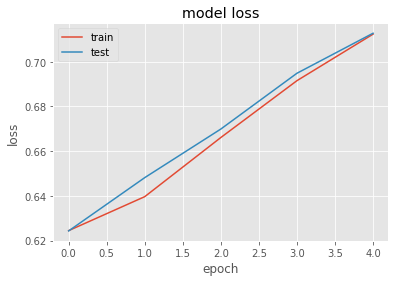

In [57]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

# make reccomendation


In [87]:
unames = ['user_id', 'gender', 'age', 'occupation', 'zip']
users = pd.read_table("/content/users.dat", sep='::',
 header=None, names=unames, engine='python')
rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_table('/content/ratings.dat', sep='::',
 header=None, names=rnames, engine='python')
mnames = ['movie_id', 'title', 'genres']
movies = pd.read_table('/content/movies.dat', sep='::',encoding = "iso8859-1",
 header=None, names=mnames, engine='python')

numpy.ndarray

In [90]:
df = pd.DataFrame(ratings, columns = rnames)

mnames = ['movie_id', 'title', 'genres']
movie_df = pd.read_table('/content/movies.dat', sep='::',encoding = "iso8859-1",
 header=None, names=mnames, engine='python')



# Let us get a user and see the top recommendations.
user_id = ratings.user_id.sample(1).iloc[0]
movies_watched_by_user = ratings[ratings.user_id == user_id]
movies_not_watched = movie_df[
    ~movie_df["movie_id"].isin(movies_watched_by_user.movie_id.values)
]["movie_id"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movie_id.values
)
movie_df_rows = movie_df[movie_df["movie_id"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movie_id"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

105/105 [==============================] - 0s 1ms/step
Showing recommendations for user: 1140
Movies with high ratings from user
--------------------------------
Adventures of Robin Hood, The (1938) : Action|Adventure
Ruling Class, The (1972) : Comedy
Thin Blue Line, The (1988) : Documentary
Little Shop of Horrors (1986) : Comedy|Horror|Musical
From Russia with Love (1963) : Action
--------------------------------
Top 10 movie recommendations
--------------------------------
Bridges of Madison County, The (1995) : Drama|Romance
Honey, I Shrunk the Kids (1989) : Adventure|Children's|Comedy|Fantasy|Sci-Fi
Defending Your Life (1991) : Comedy|Romance
Betrayed (1988) : Drama|Thriller
Who's Harry Crumb? (1989) : Comedy
Broken Hearts Club, The (2000) : Drama
Hellraiser (1987) : Horror
Runaway (1984) : Sci-Fi|Thriller
Digimon: The Movie (2000) : Adventure|Animation|Children's
Get Carter (1971) : Thriller
